# **REINFORCE algorithm on CartPole**
## In this notebook we solve the Cartpole game using the REINFORCE algorithm coupled with a MLP.

## Acknowledgement

Code adapted from [this notebook](https://github.com/bentrevett/pytorch-rl).


## Import

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as distributions

import matplotlib.pyplot as plt
import numpy as np
import gym

## Initialize environments

In [ ]:
train_env = gym.make('CartPole-v1')
test_env = gym.make('CartPole-v1')

## Seed

In [ ]:
SEED = 42

train_env.reset(seed=SEED);
test_env.reset(seed=SEED+1);
np.random.seed(SEED);
torch.manual_seed(SEED);

## REINFORCE algorithm

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout = 0.5):
        super().__init__()

        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.fc_1(x)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.fc_2(x)
        return x

In [ ]:
INPUT_DIM = train_env.observation_space.shape[0]
HIDDEN_DIM = 128
OUTPUT_DIM = train_env.action_space.n

STATES = []

In [ ]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0)

## Training

In [ ]:
def train(env, policy, optimizer, discount_factor):
    
    policy.train()
    
    log_prob_actions = []
    rewards = []
    done = False
    episode_reward = 0
    n_samples = 0
    state, _ = env.reset()
    
    while not done:
        state = torch.FloatTensor(state).unsqueeze(0)

        action_pred = policy(state)
        
        action_prob = F.softmax(action_pred, dim = -1)
                
        dist = distributions.Categorical(action_prob)

        action = dist.sample()
        
        log_prob_action = dist.log_prob(action)
        
        state, reward, done, truncated, _ = env.step(action.item())
        done = done or truncated

        log_prob_actions.append(log_prob_action)
        rewards.append(reward)
        n_samples += 1
        episode_reward += reward

    log_prob_actions = torch.cat(log_prob_actions)
        
    returns = calculate_returns(rewards, discount_factor)
        
    loss = update_policy(returns, log_prob_actions, optimizer)

    return loss, episode_reward, n_samples

In [ ]:
def calculate_returns(rewards, discount_factor, normalize = True):
    
    returns = []
    R = 0
    
    for r in reversed(rewards):
        R = r + R * discount_factor
        returns.insert(0, R)
        
    returns = torch.tensor(returns)
    
    if normalize:
        returns = (returns - returns.mean()) / returns.std()
        
    return returns

In [ ]:
def update_policy(returns, log_prob_actions, optimizer):
    
    returns = returns.detach()
    
    loss = - (returns * log_prob_actions).sum()
    
    optimizer.zero_grad()
    
    loss.backward()
    
    optimizer.step()
    
    return loss.item()

In [ ]:
def evaluate(env, policy):
    
    policy.eval()
    
    done = False
    episode_reward = 0

    state, _ = env.reset()

    while not done:     
        state = torch.FloatTensor(state).unsqueeze(0)
        
        with torch.no_grad():
        
            action_pred = policy(state)
        
            action_prob = F.softmax(action_pred, dim = -1)
                            
        action = torch.argmax(action_prob, dim = -1)
        STATES.append(state)
       
        state, reward, done, truncated, _ = env.step(action.item())
        done = done or truncated

        episode_reward += reward
        
    return episode_reward

In [ ]:
MAX_EPISODES = 500
DISCOUNT_FACTOR = 0.99
N_TRIALS = 25
REWARD_THRESHOLD = 475
PRINT_EVERY = 10

policy = MLP(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM)
policy.apply(init_weights)

LEARNING_RATE = 0.01

optimizer = optim.Adam(policy.parameters(), lr = LEARNING_RATE)

nb_samples = [0]
train_rewards = []
test_rewards = []

for episode in range(1, MAX_EPISODES+1):
    
    loss, train_reward, n_samples = train(train_env, policy, optimizer, DISCOUNT_FACTOR)
    
    test_reward = evaluate(test_env, policy)
    
    train_rewards.append(train_reward)
    test_rewards.append(test_reward)
    nb_samples.append(n_samples + nb_samples[-1])    
    mean_train_rewards = np.mean(train_rewards[-N_TRIALS:])
    mean_test_rewards = np.mean(test_rewards[-N_TRIALS:])
    
    if episode % PRINT_EVERY == 0:
    
        print(f'| Episode: {episode:3} | Mean Train Rewards: {mean_train_rewards:5.1f} | Mean Test Rewards: {mean_test_rewards:5.1f} |')
    
    if mean_test_rewards >= REWARD_THRESHOLD:
        
        print(f'Reached reward threshold in {episode} episodes')
        
        break

nb_samples = nb_samples[1:]

| Episode:  10 | Mean Train Rewards:  26.4 | Mean Test Rewards:  26.6 |
| Episode:  20 | Mean Train Rewards:  40.0 | Mean Test Rewards:  72.3 |
| Episode:  30 | Mean Train Rewards:  53.7 | Mean Test Rewards:  88.2 |
| Episode:  40 | Mean Train Rewards:  89.8 | Mean Test Rewards: 201.0 |
| Episode:  50 | Mean Train Rewards: 115.4 | Mean Test Rewards: 322.7 |
| Episode:  60 | Mean Train Rewards: 117.2 | Mean Test Rewards: 408.4 |
| Episode:  70 | Mean Train Rewards: 110.2 | Mean Test Rewards: 374.1 |
| Episode:  80 | Mean Train Rewards: 102.8 | Mean Test Rewards: 350.6 |
| Episode:  90 | Mean Train Rewards: 105.6 | Mean Test Rewards: 276.6 |
| Episode: 100 | Mean Train Rewards:  85.8 | Mean Test Rewards: 179.9 |
| Episode: 110 | Mean Train Rewards:  73.2 | Mean Test Rewards:  85.0 |
| Episode: 120 | Mean Train Rewards:  73.0 | Mean Test Rewards:  86.8 |
| Episode: 130 | Mean Train Rewards: 107.3 | Mean Test Rewards: 123.9 |
| Episode: 140 | Mean Train Rewards: 137.0 | Mean Test Rewards: 

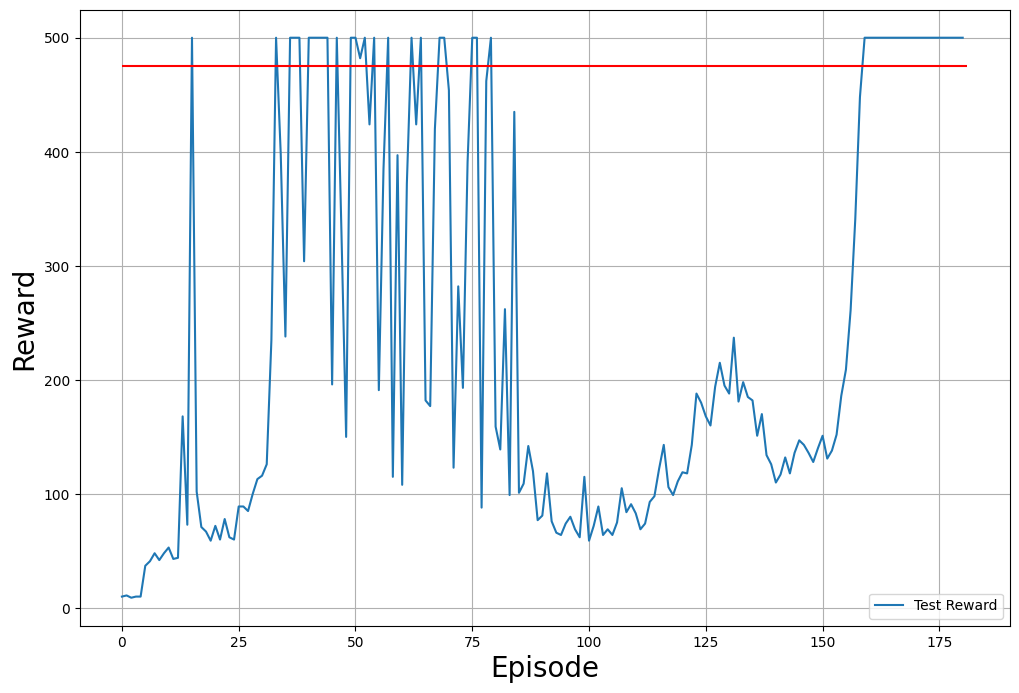

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(test_rewards, label='Test Reward')
#plt.plot(train_rewards, label='Train Reward')
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Reward', fontsize=20)
plt.hlines(REWARD_THRESHOLD, 0, len(test_rewards), color='r')
plt.legend(loc='lower right')
plt.grid()

In [ ]:
for p in policy.parameters():
    print(torch.norm(p.grad))

tensor(23.1987)
tensor(41.0984)
tensor(27.3278)
tensor(13.4015)


## Study the range of the states

To be able to adapt REINFORCE to Local Differential Privacy (LDP), we need to determine the range of values taken by the states.

In [ ]:
s1 = 0
s2 = 0
s3 = 0
s4 = 0

for state in STATES:
    s1 += np.abs(state[0, 0])
    s2 += np.abs(state[0, 1])
    s3 += np.abs(state[0, 2])
    s4 += np.abs(state[0, 3])
    
s1 /= len(STATES)
s2 /= len(STATES)
s3 /= len(STATES)
s4 /= len(STATES)

print(s1, s2, s3, s4)

tensor(0.3636) tensor(0.2821) tensor(0.0296) tensor(0.1622)


In [ ]:
import pandas as pd

df = {"s0": [], "s1": [], "s2": [], "s3": []}

for state in STATES:
    df["s0"].append(state[0, 0].item())
    df["s1"].append(state[0, 1].item())
    df["s2"].append(state[0, 2].item())
    df["s3"].append(state[0, 3].item())
    
df = pd.DataFrame(df, dtype='float')

df

,s0,s1,s2,s3
0,0.008714,-0.027529,0.025179,-0.023631
1,0.008164,0.167222,0.024707,-0.308264
2,0.011508,0.361984,0.018541,-0.593054
3,0.018748,0.556841,0.006680,-0.879839
4,0.029885,0.751872,-0.010917,-1.170415
...,...,...,...,...
42985,0.349187,0.145528,0.004770,-0.227269
42986,0.352098,-0.049662,0.000225,0.066915
42987,0.351104,0.145457,0.001563,-0.225697
42988,0.354013,-0.049687,-0.002951,0.067478


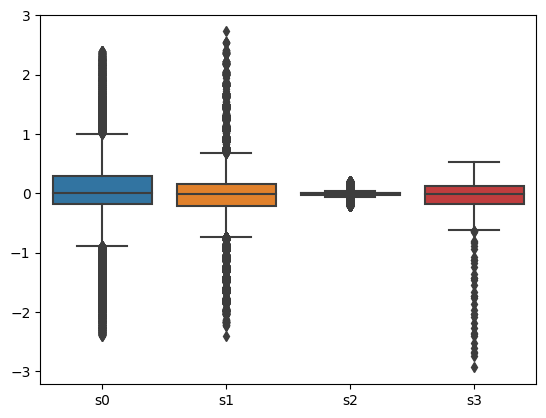

In [ ]:
import seaborn as sns

sns.boxplot(data=df)

plt.show()

## Inter Quantile Range (IQR) of the states

In [ ]:
q75, q25 = np.percentile(df['s3'], [75 ,25])
iqr = q75 - q25

print(iqr)

0.29920017533004284
